In [1]:
import sys 
path_project = '/home/danshach/pot_store/gpfs_scratch/Xalantir'
sys.path.insert(1, path_project)
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from cycler import cycler
from matplotlib import patches
from glob import glob
import re
import json
from matplotlib.lines import Line2D
from matplotlib.patches import Patch



Modification for Legend handler from https://stackoverflow.com/users/565697/gyger

In [46]:
from matplotlib.legend_handler import HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

In [4]:
path_results = path_project + '/results/'
results_round_mode = 'best' # 'average'


### Matplotlib figure style ###

In [5]:
#font = {'family' : 'sans-serif',
 #normal',
  #14}

#matplotlib.rc('font', **font)      'size'   :        'weight' : '
pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }
my_width = jour_sizes["PRD"]["onecol"]
#my_width = jour_sizes[""]

# Our figure's aspect ratio
golden = (1 + 5 ** 0.5) / 2
plt.style.use("thesis.mplstyle")
#plt.style.use('ggplot')


## Run Class ##

In [34]:
class Run:
    def __init__(self, run, run_id, param=None):
        self.morphology = run.morphology
        self.algorithm = run.algorithm
        self.id = run_id
        self.folder =  path_project + '/results/' + '_'.join(self.morphology) + '/' + self.algorithm + '/run_' + self.id
        self.param_to_compare = self.get_run_config(param)
        self.get_results_round(mode='acc_validation')
        #self.config = self.get_run_config()
    
    def get_run_config(self, param=None):
        with open(self.folder + '/config.json', 'r') as file:
            config_data = json.load(file)
        if param != None:
            param_to_compare = next((inner_dict[param] for inner_dict in config_data.values() if param in inner_dict), None)
            return param_to_compare
        else:
            return config_data
    
    def get_results_round(self, mode):
        model_scores = pd.read_csv(self.folder + '/model_scores.csv')
        best_round = model_scores.expected_MSE.idxmin()
        self.folder_run = self.folder
        self.folder += '/round_' + str(best_round)
    
    def get_simulation_prediction_values(self, morphology):
        file_path = self.folder + '/' + morphology + '_predictions_test_sim.csv'
        df = pd.read_csv(file_path, index_col=0)
        return df

    def get_simulation_prediction_values_all_rounds(self, morphology=None):
        dfs = []
        if not morphology: morphology= self.morphology[0]
        files = self.folder_run + '/round_*/' + morphology + '_predictions_test_sim.csv'
        files = sorted(glob(files))

        for file_path in files:
            df = pd.read_csv(file_path, index_col=0)
            dfs.append(df)
        return dfs
    
    def get_experiment_prediction_values(self, morphology=None, max_thickness=6.0):
        tests = {}
        if not morphology: morphology= self.morphology[0]
        test_experiment_files = self.folder + '/' + morphology + '_predictions_test_experiment_*.csv' 
        test_experiment_files = sorted(glob(test_experiment_files))
        find_test_name_in_pattern = re.compile(r'experiment_(.*?)\.csv')
        for file_path in test_experiment_files:
            test_name = find_test_name_in_pattern.search(file_path).group(1)
            df = pd.read_csv(file_path, index_col=0)
            if max_thickness:
                df = df[df['thickness']<=max_thickness]
            tests[test_name] = df
        return tests
    
    def get_experiment_prediction_values_all_rounds(self, morphology=None, max_thickness=6.0, mode=None):
        tests = {}
        if not morphology: morphology= self.morphology[0]
        
        test_experiment_files = self.folder_run + '/round_*/' + morphology + '_predictions_test_experiment_*.csv' 
        test_experiment_files = sorted(glob(test_experiment_files))
        find_test_name_in_pattern = re.compile(r'experiment_(.*?)\.csv')
        for file_path in test_experiment_files:
            test_name = find_test_name_in_pattern.search(file_path).group(1)
            if test_name not in tests:
                tests[test_name] = []
            df = pd.read_csv(file_path, index_col=0)
            if max_thickness:
                df = df[df['thickness']<=max_thickness]
            tests[test_name].append(df)
        return tests
    
    def get_morphology_interval(self, morphology):
        config_data = self.get_run_config()
        n_output_units = config_data["algorithm_parameters"]["output_units"][morpgology]
        if morphology == 'radius':
            return np.round(np.linspace(1.2, 28.1, n_output_units),1)
        if morphology == 'distance':
            return np.round(np.linspace(3.8, 41.7, n_output_units),1)
        
    def estimate_accuracy(self, thresh=1.25):
        prediction_values = self.get_experiment_prediction_values_all_rounds()
        estimate_single = {}
        estimate_all = 0
        for measurement, dfs in prediction_values.items():
            estimate_single[measurement] = []
            for df in dfs:
                n_correct = sum([1 for i in range(len(df)) if df['avg'][i]-thresh <= df['gt'][i] <= df['avg'][i]+thresh])
                estimate_single[measurement].append(np.round(n_correct/len(df),2))
        print(estimate_single)
        means = []
        for m in estimate_single:
            print(m)
            mean = np.round(np.mean(estimate_single[m]),2)
            means.append(mean)
            print(f"mean: {mean}")
            std = np.round(np.std(estimate_single[m]),2)
            print(f"std: {std}")
        print(f'over all mean: {np.round(np.mean(means),2)}, std: {np.round(np.std(means),2)}')


def darken_color(hex_color, factor=0.6):
    """ darkens the given hex color by blending with black """
    rgb = matplotlib.colors.hex2color(hex_color)
    darkened_rgb = [(1 - factor) * c for c in rgb]
    return matplotlib.colors.to_hex(darkened_rgb)


## Evaluation Class ##

In [43]:
class Evaluation_Results:
    def __init__(self, runs_map_df, param=None):
        self.runs_map = runs_map_df
        self.runs = self.get_runs(param)
    
    def get_runs(self, param=None):
        runs = []
        for i in range(len(self.runs_map)):
            trial = self.runs_map.loc[i]
            for run_id in trial.id_runs:
                run = Run(run=trial, run_id=run_id, param=param)
                runs.append(run)
        return runs
                
    def plot_simulation_predictions_with_std(self, runs=None, single_plots=True, save=False, compare='loss', thresh=0.5, desc=None, params=None, title=None):
        # plot the prediction curves for the morphology with ground truth if given
        #if runs is None that plot all runs
        runs = self.runs if not runs else [self.runs[i] for i in range(len(self.runs)) if self.runs[i].id in runs]
        # gather all data for plots
        runs_prediction_values = {}
        for run in runs:
            for morphology in run.morphology:
                prediction_values_dfs = run.get_simulation_prediction_values_all_rounds(morphology)
                if morphology not in runs_prediction_values:
                    runs_prediction_values[morphology] = {}
                    
                max_valus = []
                avg_valus = []
                estimation = []
                for prediction_values in prediction_values_dfs:
                    max_valus.append(prediction_values['max'])
                    avg_valus.append(prediction_values['avg'])
                    
                    estimation.append( \
                        sum([1 for i in range(len(prediction_values['max'])) \
                             if prediction_values['max'][i]-thresh <= prediction_values['gt'][i] <= prediction_values['max'][i]+thresh])/len(prediction_values['max']))
                    # estimation.append( \
                    #     sum([1 for i in range(len(prediction_values['avg'])) \
                    #          if prediction_values['avg'][i]-thresh <= prediction_values['gt'][i] <= prediction_values['avg'][i]+thresh])/len(prediction_values['avg']))

                max_values_avg = np.mean(max_valus, axis=0)
                avg_valus_avg = np.mean(avg_valus, axis=0)
                estimation = np.mean(estimation)
                estimation_std = np.std(estimation)
                max_values_std = np.std(max_valus, axis=0)
                avg_valus_std = np.std(avg_valus, axis=0)
                
                runs_prediction_values[morphology][run.id] = {
                    'config': run.param_to_compare,
                    'algorithm': run.algorithm,
                    'max_weight': max_values_avg, 
                    'max_std': max_values_std,
                    'expected': avg_valus_avg,
                    'expected_std': avg_valus_std,
                    'ground_truth': prediction_values['gt'].to_numpy(),
                    'estimation': estimation,
                    'estimation_std': estimation_std
                    }
                sorted_idx = np.argsort(runs_prediction_values[morphology][run.id]['ground_truth'])
                for key in ['ground_truth', 'max_weight','max_std', 'expected', 'expected_std']:
                    runs_prediction_values[morphology][run.id][key] = runs_prediction_values[morphology][run.id][key][sorted_idx]

        for morphology, run_data in runs_prediction_values.items(): # run_data = {run_id_1:{...}, run_id_2:{...}}
            if morphology == 'radius':
                min_scope = 1.2#2.5#
                max_scope = 7.5#7.1#
            elif morphology == 'distance':
                min_scope = 6.0#2.5#for run_id, values in run_data.items():
                max_scope = 15.0#7.1#
            
            plt.figure(figsize = (my_width, my_width/golden))  
            plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            colors = [matplotlib.colors.to_hex(plt.cm.tab10(i)) for i in range(10)]

            for i, (run_id, values) in enumerate(run_data.items()): # values = {ground_truth:[....], expected:[.....], ....}
                xs = []
                #for idx, (run_id, values) in enumerate(run_data.items()):
                    
                if not params:
                    k = 'run'
                    v =  run_id
                else:
                    k = list(params.keys())[0]
                    v = params[k][i]
                        
                x = np.arange(len(values['max_weight']))
                if len(x)>len(xs): 
                    xs = x
                color = colors[i]
                    #plt.plot(x, values['expected'], label=f'expected ({values["algorithm"]}_run_{run_id}), acc={np.round(values["estimation"],2)}', marker='.',markersize=0.5, color=color)#, linestyle='--'
                #plt.plot(x, values['expected'], label=fr'{k}={v:.0e} average, acc={np.round(values["estimation"],2)}',markersize=2, color=colors[idx], linewidth=2.0)#,marker=markercycle[idx])
                plt.plot(x, values['expected'], label=fr'average',color=color,linewidth=0.5,linestyle=':',alpha=0.6)#,marker=markercycle[idx])
                
                plt.fill_between(x, values['expected']-values['expected_std'], values['expected']+values['expected_std'], color=color,linewidth=0, alpha=0.3)
                
                plt.plot(x, values['max_weight'], label=fr'max_weight, {k}: {v}, acc={np.round(values["estimation"],2)*100}\%',color=color,linewidth=2.0,markersize=2)#, linestyle=':'
                    #plt.plot(x, values['max_weight'], label=fr'max_weight, {k}={v:.0e}, acc={np.round(values['estimation'],2)*100}\%',color=color,linewidth=2.0,markersize=2)#, linestyle=':'

                    #plt.plot(x, values['ground_truth'], label=f'ground_truth ({values["algorithm"]}_run_{run_id})', marker='.',markersize=0.5, color=darken_color(color))#, linestyle='-'
            plt.plot(xs, values['ground_truth'], label=f'ground_truth', marker='.',markersize=0.5, color='k')#, linestyle='-'
               
            plt.xlabel('Simulation Nr.')
            plt.ylabel(morphology + ' (nm)')
            
            #plt.title(fr'{morphology.title()} predictions - simulated data - loss: {"$\mathcal{L}_{CCE}$"}+{k}{"$R_{info}$"}')
            if not title:
                plt.title(f'{morphology.title()} predictions - simulated data - loss: $\mathcal{{L}}_{{CCE}}$ + {k}$R_{{mono}}$')
            else:
                plt.title(f'{morphology.title()} predictions - simulated data - {title}')

            #plt.title(f'{morphology.title()} predictions - simulated data - loss: $\mathcal{{L}}_{{CCE}}$ + {k}$R_{{info}}$')
            #plt.title(f'{morphology.title()} predictions - simulated data - $\mathcal{{L}}_{{CCE}}$ vs. $\mathcal{{L}}_{{MSE}}$')
            
            plt.legend(loc='upper left')
            self.fill_between(xs, morphology)
            plt.ylim((min_scope, 14 if morphology=='radius' else 25))
            plt.xlim((0, len(values['expected'])))
            if save:
                plt.savefig(f'figures/{morphology}_simulation_{desc}.png')
            plt.show()                               
                
    def plot_experiment_predictions_with_std(self, runs=None, estimate=True, thresh=0.5, save=False, desc=None, params=None, title='', colors=None): # params is a dictionary
        # plot the prediction curves for the morphology with ground truth if given
        #if runs is None that plot all runs
        runs = self.runs if not runs else [self.runs[i] for i in range(len(self.runs)) if self.runs[i].id in runs]
        
        # gather all data for plots
        runs_prediction_values = {}
        # iterate runs
        for run in runs:
            # iterate run morphology
            for morphology in run.morphology:
                if morphology not in runs_prediction_values:
                    # make new field for the morphology 
                    runs_prediction_values[morphology] = {}
                # get dictionary of data frames for run's morphology measurement prediction values {'measurement_id':<pd.DataFrame>,...}
                prediction_values_dfs = run.get_experiment_prediction_values_all_rounds(morphology) # returns: test[measurement] = [dfs]
                # iterate measurements 
                for measurement in prediction_values_dfs:
                    if run.id not in runs_prediction_values[morphology]:
                        # make new field for the run 
                         runs_prediction_values[morphology][run.id] = {}
                    # initialize main values dictionary for the plots
                    max_valus = []
                    avg_valus = []
                    for prediction_values in prediction_values_dfs[measurement]:
                        max_valus.append(prediction_values['max'])
                        avg_valus.append(prediction_values['avg'])
                    max_values_avg = np.mean(max_valus, axis=0)
                    avg_valus_avg = np.mean(avg_valus, axis=0)
                    max_values_std = np.std(max_valus, axis=0)
                    avg_valus_std = np.std(avg_valus, axis=0)

                    runs_prediction_values[morphology][run.id][measurement] = {
                        'compare': run.param_to_compare,
                        'algorithm': run.algorithm,
                        'max_weight': max_values_avg, 
                        'max_std': max_values_std,
                        'expected': avg_valus_avg,
                        'expected_std': avg_valus_std,
                        'ground_truth': prediction_values['gt'].to_numpy(),
                        'thickness': prediction_values['thickness'].to_numpy()
                        }
        # iterate morphology parameter (key) and the associate runs (values)

                    

        for morphology, runs in runs_prediction_values.items():
            if not colors:
                colors = [matplotlib.colors.to_hex(plt.cm.tab10(i)) for i in range(10)] 

            for measurement in next(iter(runs.values())).keys():
                #plt.figure(figsize = (my_width, my_width/golden), dpi=600)
                plt.figure(figsize=(4.4,2.6),dpi=200)

                #markercycle = cycler(marker=['o', '+', 'x', '*', '.', 'X'])
                #markercycle = ['X', 'D', '^', 'P', '8', '*']
                if not params:
                    params = {'run': []}
                gammas = [1e-5, 1e-3, 1e-1]
                #colorcycle = cycler(color=['blue', 'orange', 'green', 'magenta'])
                # Or use the default color cycle:
                # colorcycle = cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'])
                #plt.gca().set_prop_cycle(colorcycle * markercycle) # 
                x = next(iter(runs.values()))[measurement]['thickness']
                legend_elements = [Line2D([0], [0], color='k', linewidth=3.5, label='ground truth')]  # Ground truth
                
                for idx, (run_id, measurements) in enumerate(runs.items()):
                    if not params:
                        k = 'run'
                        v =  run_id
                    else:
                        k = list(params.keys())[0]
                        v = params[k][idx]
                    values = measurements[measurement]
                    estimation = sum([1 for i in range(len(values['expected'])) if values['expected'][i]-thresh <= values['ground_truth'][i] <= values['expected'][i]+thresh])/len(values['expected']) 
                    print(f"{v} acc= {np.round(estimation,2)}\n")

                    if idx==0:
                        lineGt, = plt.plot(x, values['ground_truth'], label=f'ground truth', color='k', linewidth=3.5)#,markersize=3, marker='.')
                    
                    #plt.plot(x, values['expected'], label=fr'{k}={v:.0e} average, acc={np.round(estimation,2)}',markersize=2, color=colors[idx], linewidth=2.0)#,marker=markercycle[idx])
                    #plt.plot(x, values['expected'], label=fr'average, {k}: {v}, acc={np.round(estimation,2)}',markersize=2, color=colors[idx], linewidth=2.0)#,marker=markercycle[idx])
                    #plt.plot(x, values['expected'], label=fr'{v} prediction average',markersize=2, color=colors[idx], linewidth=2.0)
                    lineEx, = plt.plot(x, values['expected'], label='solid',markersize=2, color=colors[idx], linewidth=2.0) #fr'{v}'
                    plt.fill_between(x, values['expected']-values['expected_std'], values['expected']+values['expected_std'], color=colors[idx],linewidth=0, alpha=0.3)
                    lineMw, = plt.plot(x, values['max_weight'],linestyle=':', alpha=0.3,markersize=1.0, color=colors[idx], linewidth=2, label=':')#,marker=markercycle[idx])
                    #plt.plot(x, values['max_weight'], label=fr'prediction max weight',linestyle=':', alpha=0.3,markersize=1.0, color=colors[idx], linewidth=2)#,marker=markercycle[idx])
                   
                    legend_elements.append((lineEx, lineMw))

                    #legend_elements.append(Line2D([0], [0], color=colors[idx], linewidth=2.0, linestyle=';', marker='|',label=fr'{v}'))

                    #legend_elements.append(Line2D([0], [0], color=colors[idx], linewidth=2.0, label=fr'{v}')) 
                    #legend_elements.append(Line2D([0], [0], color=colors[idx], linewidth=2.0, linestyle=':', alpha=0.5))

                #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
               #       fancybox=True, shadow=True, ncol=round(np.sqrt(len(runs)))+1)
                plt.xlabel('$\delta$ [nm]')
                plt.ylabel(f"$\\mathit{{{morphology.title()[0]}}}$ [nm]")
                
                #plt.title(f'{morphology.title()} - {measurement} - loss: $\mathcal{{L}}_{{CCE}}+\gamma*R_{{info}}$')
                if title:
                    plt.title(f'{morphology.title()} - {measurement} - {title}')

                #plt.title(f'{morphology.title()} - {measurement} - loss: $\mathcal{{L}}_{{CCE}}$+1e-03$R$')
                #plt.title(fr'{morphology} - {measurement} - $\sigma$/R=30% ')  - $\sigma$/R=30\%') # $\sigma$/R=10\%-35\%') #
                self.fill_between(x, morphology)
                #legend_elements.append([Patch(facecolor='gray',alpha=0.3)])
                if '100' in measurement:
                    #print(legend_elements)
                    #plt.legend(loc='upper left')
                    #plt.legend(handles=legend_elements, loc='upper left')
                    #print(['ground_truth'] + [l for li in params.values() for l in li])
                    plt.legend(legend_elements, ['ground truth'] + [l for li in params.values() for l in li],
                                handler_map = {tuple : HandlerTupleVertical()})

                if save:
                    plt.savefig(f'figures/{morphology}_{measurement}_{desc}.png',bbox_inches='tight', dpi=600)
                else:
                     plt.title(f'{morphology.title()} - {measurement}')
                plt.show() 


    def plot_all_experiment_predictions_with_std(self, run=None, estimate=True, thresh=0.5, save=False, desc=None, params=None, title='', colors=None): # params is a dictionary
        # plot the prediction curves for the morphology with ground truth if given
        #if runs is None that plot all runs
        run = self.runs[0] if not run else self.runs[run]
        
        # gather all data for plots
        run_prediction_values = {}
    
        # iterate run morphology
        for morphology in run.morphology:
            if morphology not in run_prediction_values:
                # make new field for the morphology 
                run_prediction_values[morphology] = {}
            # get dictionary of data frames for run's morphology measurement prediction values {'measurement_id':<pd.DataFrame>,...}
            prediction_values_dfs = run.get_experiment_prediction_values_all_rounds(morphology) # returns: test[measurement] = [dfs]
            
            # iterate measurements 
            for measurement in prediction_values_dfs:
                max_valus = []
                avg_valus = []
                for prediction_values in prediction_values_dfs[measurement]:
                    max_valus.append(prediction_values['max'])
                    avg_valus.append(prediction_values['avg'])
                max_values_avg = np.mean(max_valus, axis=0)
                avg_valus_avg = np.mean(avg_valus, axis=0)
                max_values_std = np.std(max_valus, axis=0)
                avg_valus_std = np.std(avg_valus, axis=0)
    
                run_prediction_values[morphology][measurement] = {
                    'compare': run.param_to_compare,
                    'algorithm': run.algorithm,
                    'max_weight': max_values_avg, 
                    'max_std': max_values_std,
                    'expected': avg_valus_avg,
                    'expected_std': avg_valus_std,
                    'ground_truth': prediction_values['gt'].to_numpy(),
                    'thickness': prediction_values['thickness'].to_numpy()
                    }
    
        # Plot all measurements                 
        for morphology in run_prediction_values:
            if not colors:
                colors = ['b','r','g','indigo']#[matplotlib.colors.to_hex(plt.cm.tab10(i)) for i in range(10)] 
            
            plt.figure(figsize=(4.4,2.6),dpi=200)
            for i, measurement in enumerate(run_prediction_values[morphology]):
                print(measurement)                
                params = run_prediction_values[morphology].keys()
                x = run_prediction_values[morphology][measurement]['thickness']
                legend_elements = []#[Line2D([0], [0], color=darken_color(colors[i]), linewidth=2.5, label='GT T=' + measurement[-4:])]  # Ground truth
                
                values = run_prediction_values[morphology][measurement]
                lineGt, = plt.plot(x, values['ground_truth'], label=f'ground truth', color=darken_color(colors[i]), linewidth=2.5)#,markersize=3, marker='.')
            
                lineEx, = plt.plot(x, values['expected'], label='solid',markersize=2, color=colors[i], linewidth=2.0) #fr'{v}'
                plt.fill_between(x, values['expected']-values['expected_std'], values['expected']+values['expected_std'], color=colors[i],linewidth=0, alpha=0.3)
                lineMw, = plt.plot(x, values['max_weight'],linestyle=':', alpha=0.3,markersize=1.0, color=colors[i], linewidth=2, label=':')#,marker=markercycle[idx])
                   
                legend_elements.append((lineEx, lineMw))
    
                plt.xlabel('$\delta$ [nm]')
                plt.ylabel(f"$\\mathit{{{morphology.title()[0]}}}$ [nm]")
                
                self.fill_between(x, morphology)
                
            plt.legend(legend_elements, ['ground truth'] + [l for l in run_prediction_values[morphology].keys()],
                                handler_map = {tuple : HandlerTupleVertical()})
    
                #if save:
                #    plt.savefig(f'figures/{morphology}_{measurement}_{desc}.png',bbox_inches='tight', dpi=600)
            plt.show() 
            
                
    def plot_real_predictions(self, runs=None, single_plots=True):
        pass

    def plot_simulation_prediction_2R_to_D(self, runs=None, single_plots=True):
        runs = self.runs if not runs else [self.runs[i] for i in range(len(self.runs)) if self.runs[i].id in runs]
        for run in runs:
            for morphology in run.morphology:
                prediction_values = run.get_simulation_prediction_values(morphology)
                if morphology not in runs_prediction_values:
                    runs_prediction_values[morphology] = {}
                runs_prediction_values[morphology][run.id] = {
                    'algorithm': run.algorithm,
                    'max_weight': prediction_values['max'].to_numpy(), 
                    'expected': prediction_values['avg'].to_numpy(),
                    'ground_truth': prediction_values['gt'].to_numpy()
                    }
        if ['distance','radius'] not in runs_prediction_values:
            return 0
        plot_values = []
        for run_idr, radius_values in runs_prediction_values['radius'].items():
            for run_idd, distance_values in runs_prediction_values['distance'].items():
                values = {
                    'expected_2R2D': radius_values['expected']*2 / distance_values['expected'],
                    'true_2R2D': radius_values['ground_truth']*2 / distance_values['ground_truth'],
                    'run_id_radius': run_idr,
                    'run_id_distance': run_idd,
                    'algorithm_radius': radius_values['algorithm'],
                    'algorithm_distance': distance_values['algorithm']
                }
                plot_values.append(values)
        if single_plots:
            for values in plot_values:
                pass
    
    def plot_experiment_prediction_2R_to_D(self, runs=None, single_plots=True, single_experiments=False, save=False):
        runs = self.runs if not runs else [self.runs[i] for i in range(len(self.runs)) if self.runs[i].id in runs]
        runs_prediction_values = {}
        for run in runs:
            for morphology in run.morphology:
                prediction_values = run.get_experiment_prediction_values(morphology)
                if morphology not in runs_prediction_values:
                    runs_prediction_values[morphology] = {}
                for measurement in prediction_values:
                    if run.id not in runs_prediction_values[morphology]:
                         runs_prediction_values[morphology][run.id] = {}
                    runs_prediction_values[morphology][run.id][measurement] = {
                        'algorithm': run.algorithm,
                        'max_weight': prediction_values[measurement]['max'].to_numpy(), 
                        'expected': prediction_values[measurement]['avg'].to_numpy(),
                        'ground_truth': prediction_values[measurement]['gt'].to_numpy(),
                        'thickness': prediction_values[measurement]['thickness'].to_numpy()
                        }
        if not all(x in runs_prediction_values.keys() for x in ['distance','radius']):
            return 0
        
        plot_values = {}
        for run_idr, radius_values in runs_prediction_values['radius'].items():
            # print(f'run_idr, radius_values: {run_idr}, {radius_values}')
            for measurement in radius_values:
                if measurement not in plot_values:
                    plot_values[measurement] = []
                for run_idd, distance_values in runs_prediction_values['distance'].items():
                    values = {
                        'thickness': distance_values[measurement]['thickness'],
                        'expected_2R2D': radius_values[measurement]['expected']*2 / distance_values[measurement]['expected'],
                        'true_2R2D': radius_values[measurement]['ground_truth']*2 / distance_values[measurement]['ground_truth'],
                        'run_id_radius': run_idr,
                        'run_id_distance': run_idd,
                        'algorithm_radius': radius_values[measurement]['algorithm'],
                        'algorithm_distance': distance_values[measurement]['algorithm']
                    }
                    plot_values[measurement].append(values)
        for measurement, values_list in plot_values.items():
            if single_plots:
                for values in values_list:
                    plt.figure(figsize=(8, 5))
                    x = values['thickness']
                    plt.plot(x, values['expected_2R2D'], label='average', color='g',linestyle='-',marker='.',markersize=2)
                    plt.plot(x, values['true_2R2D'], label='ground truth', color='k',linestyle='-',marker='.',markersize=2)
                    plt.ylabel('2R/D')
                    plt.xlabel('layer thickness (nm)')
                    plt.xlim(x.min(),x.max())
                    plt.ylim(0.0,2.0)
                    plt.legend()
                    plt.tight_layout()
                    plt.title(f'2R/D for {measurement}\nradius {values["algorithm_radius"]} - {values["run_id_radius"]}, distance {values["algorithm_distance"]} - {values["run_id_distance"]}')
                    plt.show()
            else:
                colors = [matplotlib.colors.to_hex(plt.cm.tab10(i)) for i in range(10)] 
                plt.figure(figsize=(8, 5))
                for idx, values in enumerate(values_list):
                    color = colors[idx]
                    x = values['thickness']
                    label_expected = f'Expected R - {values["algorithm_radius"]} - {values["run_id_radius"]}, D - {values["algorithm_distance"]} - {values["run_id_distance"]}'
                    # label_true = f'Ground True R - {values["algorithm_radius"]} - {values["run_id_radius"]}, D - {values["algorithm_distance"]} - {values["run_id_distance"]}'
                    plt.plot(x, values['expected_2R2D'], label=label_expected, color=color, linestyle='-',marker='.',markersize=2)
                plt.plot(x, values['true_2R2D'], label='ground truth', color='k',linestyle='-',marker='.',markersize=2)
                plt.ylabel('2R/D')
                plt.xlabel('layer thickness (nm)')
                plt.xlim(x.min(),x.max())
                plt.ylim(0.0,2.0)
                plt.legend()
                plt.title(f'2R/D for {measurement}')
                if save:
                    plt.savefig(f'{morphology}_{measurement}.png')
                plt.show()
    
    def plot_experiment_prediction_2R_to_D_sidebyside(self, runs=None, single_plots=True, single_experiments=False, save=False, group_by='loss'):
        """
        Plots the ratio of twice the radius (2R) to the distance (D) for experimental data, 
        comparing predicted and ground truth values.

        Parameters:
        - runs (list): List of runs to plot. If None, uses all runs.
        - single_plots (bool): If True, each plot is displayed separately. If False, combined plots are shown.
        - single_experiments (bool): If True, plots each experiment separately within the same run.
        - save (bool): If True, saves the plots as images.
        """
        runs = self.runs if not runs else [self.runs[i] for i in range(len(self.runs)) if self.runs[i].id in runs]
        # Gather prediction values
        runs_prediction_values = {}
        for run in runs:
            for morphology in run.morphology:
                prediction_values = run.get_experiment_prediction_values(morphology)
                if morphology not in runs_prediction_values:
                    runs_prediction_values[morphology] = {}
                for measurement in prediction_values:
                    if run.id not in runs_prediction_values[morphology]:
                        runs_prediction_values[morphology][run.id] = {}
                    runs_prediction_values[morphology][run.id][measurement] = {
                        'compare': run.param_to_compare,
                        'algorithm': run.algorithm,
                        'max_weight': prediction_values[measurement]['max'].to_numpy(), 
                        'expected': prediction_values[measurement]['avg'].to_numpy(),
                        'ground_truth': prediction_values[measurement]['gt'].to_numpy(),
                        'thickness': prediction_values[measurement]['thickness'].to_numpy()
                    }

        # Ensure required morphologies are available
        if not all(x in runs_prediction_values.keys() for x in ['distance', 'radius']):
            print("Required morphologies 'radius' and 'distance' are not available in the runs.")
            return

        # Calculate 2R/D ratios
        plot_values = {}
        for run_idr, radius_values in runs_prediction_values['radius'].items():
            for measurement in radius_values:
                if measurement not in plot_values:
                    plot_values[measurement] = []
                for run_idd, distance_values in runs_prediction_values['distance'].items():
                    
                    max_num_data = min(len(distance_values[measurement]['thickness']), len(radius_values[measurement]['thickness']))
                    if radius_values[measurement]['compare']==distance_values[measurement]['compare']:
                        values = {
                            'thickness': distance_values[measurement]['thickness'][:max_num_data],
                            'expected_2R2D': (radius_values[measurement]['expected'][:max_num_data] * 2) / distance_values[measurement]['expected'][:max_num_data],
                            'true_2R2D': (radius_values[measurement]['ground_truth'][:max_num_data] * 2) / distance_values[measurement]['ground_truth'][:max_num_data],
                            'run_id_radius': run_idr,
                            'run_id_distance': run_idd,
                            'algorithm_radius': radius_values[measurement]['algorithm'],
                            'algorithm_distance': distance_values[measurement]['algorithm'],
                            'loss_radius': radius_values[measurement]['compare'],
                            'loss_distance': distance_values[measurement]['compare']
                        }
                        plot_values[measurement].append(values)
        # Plotting
        for measurement, values_list in plot_values.items():
            if single_plots:
                for i in range(0, len(values_list), 2):
                    # create side-by-side subplots
                    fig, axes = plt.subplots(1, 2, figsize=(my_width, my_width/golden))#(16, 5))
                    for j, ax in enumerate(axes):
                        if i + j < len(values_list):
                            values = values_list[i + j]
                            x = values['thickness']
                            ax.plot(x, values['expected_2R2D'], label='average', color='g', linestyle='-', marker='.', markersize=2)
                            ax.plot(x, values['true_2R2D'], label='ground truth', color='k', linestyle='-', marker='.', markersize=2)
                            ax.set_ylabel('2R/D')
                            ax.set_xlabel('layer thickness (nm)')
                            ax.set_xlim(x.min(), x.max())
                            ax.set_ylim(0.0, 2.0)
                            ax.legend()
                            ax.set_title(
                                f'2R/D for {measurement}\nRadius: {values["algorithm_radius"]} (Run: {values["run_id_radius"]}), '
                                f'Distance: {values["algorithm_distance"]} (Run: {values["run_id_distance"]})'
                            )
                    #plt.tight_layout()
                    plt.show()
                    if save:
                        fig.savefig(f'{measurement}_pair_{i//2}.png')
        if not single_plots:
            # Define colors and plot layout
            colors = [matplotlib.colors.to_hex(plt.cm.tab10(i)) for i in range(10)]
            num_measurements = len(plot_values)
            num_cols = 2  # We want two measurements side by side
            num_rows = (num_measurements + 1) // num_cols  # Compute the number of rows needed

            fig, axes = plt.subplots(num_rows, num_cols, figsize=(my_width, 2*my_width/golden))#(18, 7 * num_rows))
            axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

            # Plot each measurement in its own subplot
            for idx, (measurement, values_list) in enumerate(plot_values.items()):
                ax = axes[idx]
                max_data_index = np.argmin([len(values_list[i]['thickness']) for i in range(len(values_list))])
                max_data_num = min([len(values_list[i]['thickness']) for i in range(len(values_list))])
                for idv, values in enumerate(values_list):
                    x = values_list[max_data_index]['thickness']

                    ax.plot(
                        x, values['expected_2R2D'][:max_data_num],
                        label=f'{values["loss_radius"]}',
                        # label=f'Expected R: {values["algorithm_radius"]} (Run: {values["run_id_radius"]}), '
                        #       f'D: {values["algorithm_distance"]} (Run: {values["run_id_distance"]})',
                        color=colors[idv % len(colors)], linestyle='-', linewidth=2)
                    
                    if idv==len(values_list)-1:
                        ax.plot(
                            x, values['true_2R2D'][:max_data_num],
                            label='ground truth', color='black', linestyle='-', linewidth=2#marker='.', markersize=2
                        )

                ax.set_ylabel('2R/D')
                ax.set_xlabel('layer thickness (nm)')
                ax.set_xlim(x.min(), x.max())
                ax.set_ylim(0.0, 2.0)
                ax.legend(loc='upper left',# bbox_to_anchor=(0.5, -0.1),
                          fancybox=True, shadow=False, ncol=1)
                ax.set_title(f'2R/D - {measurement}')

            # Hide any unused subplots
            for idx in range(num_measurements, len(axes)):
                axes[idx].axis('off')

            #plt.tight_layout()
            fig.subplots_adjust(wspace=0.3, hspace=0.3)

            if save:
                plt.savefig('measurements_combined.png')
            plt.show()

    def plot_histogramm_experiment(self):
        pass
        # plot test simulation data prediction histogram of densenets
       # plot_histogramm(folders=['results_final/data/densenet121', 'results_final/data/densenet169', 'results_final/data/densenet201'],
                        # models=['densenet121', 'densenet169', 'densenet201'],
                        # filenames=['densenet121_prediction_simulation_test_0.33_256_25_sf37_final.csv', 'densenet169_prediction_simulation_test_0.33_256_25_sf37_mae.csv', 'densenet201_prediction_simulation_test_0.33_256_25_sf37_final.csv'])

    def plot_histogramm_simulation(self, runs=None, buckets=None, labels=None, save=False, desc=None):
        colors=['blue', 'red', 'green', 'orange', 'brown']
        param = self.runs[0].morphology[0]
        # get the data sets for prediction vs ground truth
        runs_prediction_results = []
        runs_prediction_results_avg = []
        for i, run in enumerate(self.runs):
            simulation_prediction_results = run.get_simulation_prediction_values_all_rounds()
            runs_prediction_results.append([])
            
            runs_prediction_results_avg.append([])

            for round_df in simulation_prediction_results:
                absolut_error = np.abs(round_df['max'] - round_df['gt'])
                avg_error = np.abs(round_df['avg'] - round_df['gt'])
                runs_prediction_results[i].extend(absolut_error)
                runs_prediction_results_avg[i].extend(avg_error)

            
        for i,res in enumerate(runs_prediction_results):
            res_avg = runs_prediction_results_avg[i]
            print(f"\n{labels[i]}\nerror below 1.00 nm: {len(np.array(res)[(np.array(res)<=1.00)])/len(np.array(res))}")
            # print(f"error below 0.5 nm: {len(np.array(res)[(np.array(res)<=0.5)])/len(np.array(res))}")
            # print(f"error below 0.25 nm: {len(np.array(res)[(np.array(res)<=0.25)])/len(np.array(res))}")
            print(f"\nerror above 0.5 nm: {len(np.array(res)[(np.array(res)>0.5)])/len(np.array(res))}")
            print(f"error above 1.0 nm: {len(np.array(res)[(np.array(res)>1.0)])/len(np.array(res))}")
#             print(f"error above 0.75 nm: {len(np.array(res)[(np.array(res)>0.75)])/len(np.array(res))}")

#             print(f"\n(AVG) error above 0.5 nm: {len(np.array(res_avg)[(np.array(res_avg)>0.5)])/len(np.array(res_avg))}")
#             print(f"\n(AVG) error above 1.0 nm: {len(np.array(res_avg)[(np.array(res_avg)>1.0)])/len(np.array(res_avg))}")
        weights = []
        for i in range(len(runs_prediction_results)):
            weights.append([100 / len(runs_prediction_results[i])] * len(runs_prediction_results[i]))
        
        fig, ax1 = plt.subplots(dpi=600)
        plt.hist(runs_prediction_results, weights=weights, 
                 align='mid',
                 color=[colors[i] for i in range(len(self.runs))],
                 range=(0.00, 2.5) #
                 #bins=15 if param=='radius' else 30
                 )
        
        #ax1.set_xlim(0, 1.5)
        plt.xlim((0, 2.5))# if param=='radius' else (0,2))

        xticks=np.arange(0.00, 2.5, 0.25) #if param=='radius' else np.arange(0.00, 2.5, 0.15)
        plt.xticks(xticks)
        plt.ylabel(r'Frequency [\%]')
        plt.xlabel(fr'Absolute error {"$D$" if param=="distance" else "$R$"} [nm]')
        plt.legend(labels=labels, loc='upper right')
        plt.tight_layout()
        if save:
            plt.savefig(f'figures/{param}_error_histogram_{desc}.png',bbox_inches='tight', dpi=600)

    
    def plot_real_prediction_2R_to_D(self, runs=None, single_plots=True):
        pass
    
    def plot_compare_results_simulation_experiment(self, runs=None, single_plots=True):
        # compare experiment predictions and gt with simulation predictions and ground truth
        pass
    
    def fill_between(self,x, morphology):
        if morphology == 'radius':
            min_scope = 1.5#2.5#
            max_scope = 7.5#7.1#
            plt.ylim((0,14))
            plt.xlim((1,6))

        elif morphology == 'distance':
            min_scope = 6.0#2.5#
            max_scope = 15.0#7.1#
            plt.ylim((5.0,25))
            plt.xlim((1,6))

        else: 
            min_scope = 0#2.5#
            max_scope = 0#7.1#
        plt.fill_between(x,min_scope,max_scope,facecolor='gray', alpha=0.3, label='training scope')

#### Unused Functions

In [ ]:
    # single_plots :: if Fals, runs with same morphology will be ploted on same figure,
    # single_experiments :: if False experiments with same morphology will be ploted on same figure,
    def plot_simulation_predictions(self, runs=None, single_plots=True, save=False, compare='loss'):
        # plot the prediction curves for the morphology with ground truth if given
        #if runs is None that plot all runs
        runs = self.runs if not runs else [self.runs[i] for i in range(len(self.runs)) if self.runs[i].id in runs]
        # gather all data for plots
        runs_prediction_values = {}
        for run in runs:
            for morphology in run.morphology:
                prediction_values = run.get_simulation_prediction_values(morphology)
                if morphology not in runs_prediction_values:
                    runs_prediction_values[morphology] = {}
                runs_prediction_values[morphology][run.id] = {
                    'config': run.param_to_compare,
                    'algorithm': run.algorithm,
                    'max_weight': prediction_values['max'].to_numpy(), 
                    'expected': prediction_values['avg'].to_numpy(),
                    'ground_truth': prediction_values['gt'].to_numpy()
                    }
                sorted_idx = np.argsort(runs_prediction_values[morphology][run.id]['ground_truth'])
                for key in ['ground_truth', 'max_weight', 'expected']:
                    runs_prediction_values[morphology][run.id][key] = runs_prediction_values[morphology][run.id][key][sorted_idx]

        for morphology, run_data in runs_prediction_values.items(): 
            if morphology == 'radius':
                min_scope = 1.5#2.5#
                max_scope = 7.5#7.1#
            elif morphology == 'distance':
                min_scope = 6.0#2.5#
                max_scope = 15.0#7.1#
            if single_plots:
                for run_id, values in run_data.items():
                    plt.figure(figsize = (my_width, my_width/golden))
                    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
                    x = np.arange(len(values['max_weight']))
                    plt.fill_between(x,min_scope,max_scope,facecolor='gray', alpha=0.3, label='Training scope')
                    plt.plot(x, values['expected'], label='average', marker='.',markersize=2,linestyle='-', linewidth=0.5,color='green')
                    plt.plot(x, values['max_weight'], label='max_weight', marker='.',markersize=2,linestyle='-', linewidth=0.5,color='red', alpha=0.3)
                    plt.plot(x, values['ground_truth'], label='ground_truth', marker='.',markersize=2,linestyle='-', linewidth=0.5, color='k')
                    plt.legend(loc='upper left')
                    plt.xlabel('simulation Nr.')
                    plt.ylabel(morphology + ' (nm)')
                    title = f'Comparison of prediction for {values["algorithm"]}, run: {run_id}'
                    if compare != None: 
                        title += f', {compare}: {values["config"][compare]}'
                    plt.title(title) 
                    plt.ylim((min_scope, 14 if morphology=='radius' else 25))
                    plt.xlim((0, len(values['expected'])))
                    if save:
                        plt.savefig(f'plot_{morphology}_{run_id}.png')
                    plt.show() 
            else:
                plt.figure(figsize = (my_width, my_width/golden))
                plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
                colors = [matplotlib.colors.to_hex(plt.cm.tab10(i)) for i in range(10)]
                #colors = plt.cm.tab10(np.linspace(0, 1, len(run_data)))
                xs = []
                for idx, (run_id, values) in enumerate(run_data.items()):
                    x = np.arange(len(values['max_weight']))
                    if len(x)>len(xs): xs = x
                    color = colors[idx]
                    plt.plot(x, values['expected'], label=f'expected ({values["algorithm"]}_run_{run_id})', marker='.',markersize=0.5, color=color)#, linestyle='--'
                    plt.plot(x, values['max_weight'], label=f'max_weight ({values["algorithm"]}_run_{run_id})', marker='.', color=color,markersize=0.5, alpha=0.3)#, linestyle=':'
                    plt.plot(x, values['ground_truth'], label=f'ground_truth ({values["algorithm"]}_run_{run_id})', marker='.',markersize=0.5, color=darken_color(color))#, linestyle='-'
                plt.xlabel('Simulation Nr.')
                plt.ylabel(morphology + ' (nm)')
                plt.title(f'Comparison of predictions for morphology: {morphology}')
                plt.legend(loc='upper left')
                self.fill_between(xs, morphology)
                if save:
                    plt.savefig(f'plot_{morphology}_combined.png')
                plt.show()


def plot_experiment_predictions(self, runs=None, single_runs=False, single_measurement=True, save=False, desc=None):
        # plot the prediction curves for the morphology with ground truth if given
        #if runs is None that plot all runs
        runs = self.runs if not runs else [self.runs[i] for i in range(len(self.runs)) if self.runs[i].id in runs]
        
        # gather all data for plots
        runs_prediction_values = {}
        # iterate runs
        for run in runs:
            # iterate run morphology
            for morphology in run.morphology:
                if morphology not in runs_prediction_values:
                    # make new field for the morphology 
                    runs_prediction_values[morphology] = {}
                # get dictionary of data frames for run's morphology measurement prediction values {'measurement_id':<pd.DataFrame>,...}
                prediction_values = run.get_experiment_prediction_values(morphology)
                # iterate measurements 
                for measurement in prediction_values:
                    if run.id not in runs_prediction_values[morphology]:
                        # make new field for the run 
                         runs_prediction_values[morphology][run.id] = {}
                    # initialize main values dictionary for the plots
                    runs_prediction_values[morphology][run.id][measurement] = {
                        'compare': run.param_to_compare,
                        'algorithm': run.algorithm,
                        'max_weight': prediction_values[measurement]['max'].to_numpy(), 
                        'expected': prediction_values[measurement]['avg'].to_numpy(),
                        'ground_truth': prediction_values[measurement]['gt'].to_numpy(),
                        'thickness': prediction_values[measurement]['thickness'].to_numpy()
                        }
        # iterate morphology parameter (key) and the associate runs (values)
        for morphology, runs in runs_prediction_values.items():
            colors = [matplotlib.colors.to_hex(plt.cm.tab10(i)) for i in range(10)] 

            # plot each run in single figure
            if single_runs:
                # iterate runs (key) and the associated measurements (values)
                for run_id, measurements in runs.items():
                    
                    if single_measurement:
                        # plot each measurement in single figure
                        for measurement, values in measurements.items():
                            plt.figure(figsize = (my_width, my_width/golden))
                            x = values['thickness']
                            plt.plot(x, values['expected'], label='average', color='g',linestyle='-',marker='.',markersize=2)
                            plt.plot(x, values['max_weight'], label='max weight', color='r', alpha=0.3,linestyle='-',marker='.',markersize=2)
                            plt.plot(x, values['ground_truth'], label='ground truth', color='k',linestyle='-',marker='.',markersize=2)
                            plt.legend(loc='upper left')
                            plt.xlabel('layer thickness (nm)')
                            plt.ylabel(morphology + ' (nm)')
                            title = f'{values["algorithm"]} - {morphology} - {run_id} - {measurement}'
                            if values['compare'] != None:
                                title += f' - {values["compare"] }'
                            plt.title(title)
                            self.fill_between(x, morphology)                            
                            if save:
                                plt.savefig(f'{morphology}_{run_id}_{measurement}.png')
                            plt.show()
                    else:
                        # plot all measurements in single run figure
                        plt.figure(figsize = (my_width, my_width/golden))
                        xs = []
                        for idx, (measurement, values) in enumerate(measurements.items()):
                            x = values['thickness']
                            if len(x)>len(xs): xs = x
                            plt.plot(x, values['ground_truth'], label=f'{measurement} Ground Truth', marker='.', color=darken_color(colors[idx]))
                            plt.plot(x, values['expected'], label=f'{measurement} Expected', marker='.',markersize=0.5, color=colors[idx])
                            plt.plot(x, values['max_weight'], label=f'{measurement} Max Weight', marker='.',markersize=0.5, alpha=0.3, color=colors[idx])
                        plt.legend(loc='upper left')
                        plt.xlabel('layer thickness (nm)')
                        plt.ylabel(morphology + ' (nm)')
                        
                        title = f'{morphology} - {run_id}'
                        if values['compare'] != None:
                            title += f' - {values["compare"] }'
                        plt.title(title)
                        
                        self.fill_between(xs, morphology)
                        if save:
                            plt.savefig(f'{morphology}_{run_id}.png')
                        plt.show()
            # else   
            # plot each measurement in single figure with all runs 
            if not single_runs and single_measurement:

                for measurement in next(iter(runs.values())).keys():
                    plt.figure(figsize = (my_width, my_width/golden))
                    #markercycle = cycler(marker=['o', '+', 'x', '*', '.', 'X'])
                    markercycle = ['X', 'D', '^', 'P', '8', '*']

                    #colorcycle = cycler(color=['blue', 'orange', 'green', 'magenta'])
                    # Or use the default color cycle:
                    # colorcycle = cycler(color=plt.rcParams['axes.prop_cycle'].by_key()['color'])
                    #plt.gca().set_prop_cycle(colorcycle * markercycle) # 
                    x = next(iter(runs.values()))[measurement]['thickness']
                    for idx, (run_id, measurements) in enumerate(runs.items()):
                        values = measurements[measurement]
                        if idx==0:
                            plt.plot(x, values['ground_truth'], label=f'ground truth', color='k', linewidth=3.5)#,markersize=3, marker='.')
                        #plt.plot(x, values['expected'], label=f'{values["algorithm"]} - {run_id} {values["compare"]} average', marker='.',markersize=2, color=colors[idx])
                        #plt.plot(x, values['max_weight'], label=f'{values["algorithm"]} - {run_id} {values["compare"]} max weight', marker='.',linestyle='--', alpha=0.3,markersize=2, color=colors[idx])
                        plt.plot(x, values['expected'], label=f'{values["compare"]} average',markersize=2, color=colors[idx], linewidth=2.0)#,marker=markercycle[idx])
                        plt.plot(x, values['max_weight'], label=f'{values["compare"]} max weight',linestyle=':', alpha=0.3,markersize=1.0, color=colors[idx], linewidth=2)#,marker=markercycle[idx])

                    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                   #       fancybox=True, shadow=True, ncol=round(np.sqrt(len(runs)))+1)
                    plt.xlabel('layer thickness (nm)')
                    plt.ylabel(morphology + ' (nm)')
                    plt.title(fr'{morphology.title()} - {measurement}')
                    #plt.title(fr'{morphology} - {measurement} - $\sigma$/R=30% ')  - $\sigma$/R=30\%') # $\sigma$/R=10\%-35\%') #

                    self.fill_between(x, morphology)
                    plt.legend(loc='upper left')

                    if save:
                        plt.savefig(f'figures/{morphology}_{measurement}_{desc}.png')
                    plt.show()

In [47]:
runs_radius = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['124','125','123']]}
runs_radius_df = pd.DataFrame(runs_radius)
evaluation_radius = Evaluation_Results(runs_radius_df, 'beta')

sputter_100K
sputter_300K
sputter_400K
sputter_500K


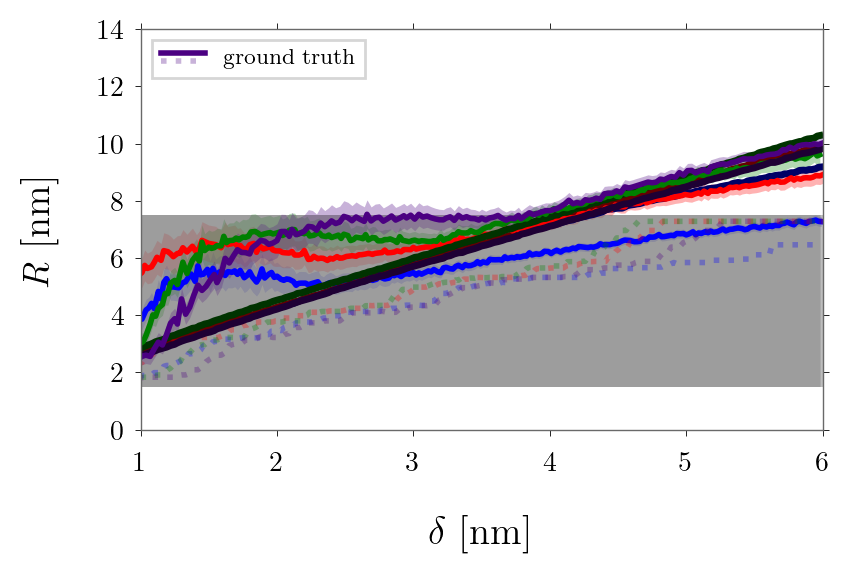

In [48]:
evaluation_radius.plot_all_experiment_predictions_with_std(params={'run':['R124', 'R125', 'R123']})

In [ ]:
evaluation_radius.plot_experiment_predictions_with_std(params={'run':['R124', 'R125', 'R123']})

## Distance
### Comparison of loss functions

In [ ]:
runs_map_distance_sim = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['66','65','67']]}
runs_map_distance_sim_df = pd.DataFrame(runs_map_distance_sim)
evaluation_distance_sim = Evaluation_Results(runs_map_distance_sim_df, 'beta')

runs_map_distance_reduced = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['63','64','60']]}
runs_map_distance_reduced_df = pd.DataFrame(runs_map_distance_reduced)
evaluation_distance_reduced = Evaluation_Results(runs_map_distance_reduced_df, 'beta')

runs_map_distance_exp = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['62','59','58']]}
runs_map_distance_exp_df = pd.DataFrame(runs_map_distance_exp)
evaluation_distance_exp = Evaluation_Results(runs_map_distance_exp_df, 'beta')

In [ ]:
evaluation_distance_reduced.plot_histogramm_simulation(labels=['${L}_{{MSE}}$ (D3)','${L}_{{CCE}}$ (D5)','${L}_{{KLD}}$ (D7)'], save=True, desc='Loss_Function_Comparison-reduced_validation')

In [ ]:
evaluation_distance_exp.plot_histogramm_simulation(labels=['${L}_{{MSE}}$ (D2)','${L}_{{CCE}}$ (D4)','${L}_{{KLD}}$ (D6)'], save=False, desc='Loss_Function_Comparison-sim_validation')

In [ ]:
evaluation_distance_sim.plot_histogramm_simulation(labels=['${L}_{{MSE}}$ (D2)','${L}_{{CCE}}$ (D4)','${L}_{{KLD}}$ (D6)'], save=True, desc='Loss_Function_Comparison-sim_validation')

In [ ]:
evaluation_distance_reduced.plot_experiment_predictions_with_std(desc='MSEvsCCEvsKLD-reduced_validation-narrow_sigma-one_hot',thresh=1.0, save=True, params={'loss':['${L}_{{MSE}}$ (D3)','${L}_{{CCE}}$ (D5)','${L}_{{KLD}}$ (D7)']}, title=None, colors=['blue','red','green'])

In [ ]:
evaluation_distance_sim.plot_experiment_predictions_with_std(desc='MSEvsCCEvsKLD-sim_validation-narrow_sigma-one_hot',thresh=0.5, save=True, params={'loss':['${L}_{{MSE}}$ (D2)','${L}_{{CCE}}$ (D4)','${L}_{{KLD}}$ (D6)']}, title=None, colors=['blue','red','green'])

In [ ]:
evaluation_distance_exp.plot_experiment_predictions_with_std(desc='MSEvsCCEvsKLD-sim_validation-narrow_sigma-one_hot',thresh=1.0, save=False, params={'loss':['$\mathcal{{L}}_{{MSE}}$','$\mathcal{{L}}_{{CCE}}$','$\mathcal{{L}}_{{KLD}}$']}, title=None, colors=['blue','red','green'])

## Radius
### Comparison of loss functions

In [ ]:
runs_map_radius_sim = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['128','127','126']]}
runs_map_radius_sim_df = pd.DataFrame(runs_map_radius_sim)
evaluation_radius_sim = Evaluation_Results(runs_map_radius_sim_df, 'beta')

runs_map_radius_reduced = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['124','125','123']]}
runs_map_radius_reduced_df = pd.DataFrame(runs_map_radius_reduced)
evaluation_radius_reduced = Evaluation_Results(runs_map_radius_reduced_df, 'beta')

runs_map_radius_exp = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['130','131','129']]}
runs_map_radius_exp_df = pd.DataFrame(runs_map_radius_exp)
evaluation_radius_exp = Evaluation_Results(runs_map_radius_exp_df, 'beta')

In [ ]:
evaluation_radius_exp.plot_experiment_predictions_with_std(desc='MSEvsCCEvsKLD-exp_validation-narrow_sigma-one_hot',thresh=1.0, save=False, params={'loss':['$\mathcal{{L}}_{{MSE}}$','$\mathcal{{L}}_{{CCE}}$','$\mathcal{{L}}_{{KLD}}$']}, title=None, colors=['blue','red','green'])

In [ ]:
evaluation_radius_reduced.plot_experiment_predictions_with_std(desc='MSEvsCCEvsKLD-reduced_validation-narrow_sigma-one_hot',thresh=1.0, save=True, params={'loss':['${L}_{{MSE}}$ (R3)','${L}_{{CCE}}$ (R5)','${L}_{{KLD}}$ (R7)']}, title=None, colors=['blue','red','green'])

In [ ]:
evaluation_radius_sim.plot_experiment_predictions_with_std(desc='MSEvsCCEvsKLD-sim_validation-narrow_sigma-one_hot',thresh=0.5, save=True, params={'loss':['${L}_{{MSE}}$ (R2)','${L}_{{CCE}}$ (R4)','${L}_{{KLD}}$ (R6)']}, title=None, colors=['blue','red','green'])

In [ ]:
evaluation_radius_sim.plot_histogramm_simulation(labels=['${L}_{{MSE}}$ (R2)','${L}_{{CCE}}$ (R4)','${L}_{{KLD}}$ (R6)'], save=True, desc='Loss_Function_Comparison-sim_validation')

In [ ]:
evaluation_radius_reduced.plot_histogramm_simulation(labels=['${L}_{{MSE}}$ (R3)','${L}_{{CCE}}$ (R5)','${L}_{{KLD}}$ (R7)'], save=True, desc='Loss_Function_Comparison-exp-reduced_validation')

In [ ]:
evaluation_radius_exp.plot_histogramm_simulation(labels=['$\mathcal{{L}}_{{MSE}}$','$\mathcal{{L}}_{{CCE}}$','$\mathcal{{L}}_{{KLD}}$'], save=False, desc='Loss_Function_Comparison-sim_validation')

### Distance Regulerized

In [ ]:
runs_map_distance_mono = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['64','69','77']]}#]]}
    #'id_runs': [['64','68','69','77']]}#]]}
runs_map_distance_mono_df = pd.DataFrame(runs_map_distance_mono)
evaluation_distance_mono = Evaluation_Results(runs_map_distance_mono_df, 'beta')

runs_map_distance_informed = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    #'id_runs': [['64','76','72']]}#,'71','70']]}
    'id_runs': [['64','72','71']]}
runs_map_distance_informed_df = pd.DataFrame(runs_map_distance_informed)
evaluation_distance_informed = Evaluation_Results(runs_map_distance_informed_df, 'beta')

In [ ]:
evaluation_distance_informed.plot_experiment_predictions_with_std(
    desc='InfoReg-reduced_validation-narrow_sigma-one_hot',thresh=1.0, save=True, 
    #params={'loss':['w/o reg.','info reg. $\gamma$=0.00001','info reg. $\gamma$=0.001','info reg. $\gamma$=1','info reg. $\gamma$=10']}, 
    params={'loss':['w/o reg. (D5)','$R_{info}$, $\gamma=10^{-3}$ (D10)','$R_{info}$, $\gamma=1$ (D11)']},
    title=None, colors=['blue','red','green'])#, 'orange','brown'])

In [ ]:
evaluation_distance_mono.plot_experiment_predictions_with_std(
    desc='MonoReg-reduced_validation-narrow_sigma-one_hot',thresh=1.0, save=True, 
    #params={'loss':['w/o reg.','monotonic reg. $\gamma$=0.00001','monotonic reg. $\gamma$=0.001','monotonic reg. $\gamma$=1']}, 
    params={'loss':['w/o reg. (D5)','$R_{mono}$, $\gamma=10^{-3}$ (D8)','$R_{mono}$, $\gamma$=1 (D9)']}, 
    title=None, colors=['blue','red','green'])#, 'orange','brown'])

In [ ]:
evaluation_distance_informed.plot_histogramm_simulation(
    labels= ['w/o reg. (D5)','$R_{info}$, $\gamma=10^{-3}$ (D10)','$R_{info}$, $\gamma=1$ (D11)'], 
    #labels= ['w/o reg.','info reg. $\gamma$=0.00001',
    #         'info reg. $\gamma$=0.001','info reg. $\gamma$=1','info reg. $\gamma$=10'], 
    save=True, desc='Info-Reg_sim_Comparison-exp-reduced_validation')

In [ ]:
evaluation_distance_mono.plot_histogramm_simulation(
    #labels= ['w/o reg.','monotonic reg. $\gamma$=0.00001','monotonic reg. $\gamma$=0.001','monotonic reg. $\gamma$=1'], 
    labels=['w/o reg. (D5)','$R_{mono}$, $\gamma=10^{-3}$ (D8)','$R_{mono}$, $\gamma$=1 (D9)'], 
    save=True, desc='Mono-Reg_sim_Comparison-exp-reduced_validation')

### Radius Regulerized

In [ ]:
runs_map_radius_mono = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    #'id_runs': [['125','132','133']]}#,'136']]}
    'id_runs': [['125','133','136']]}
runs_map_radius_mono_df = pd.DataFrame(runs_map_radius_mono)
evaluation_radius_mono = Evaluation_Results(runs_map_radius_mono_df, 'beta')

runs_map_radius_mono_MSE = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['124','134','135']]}
runs_map_radius_mono_MSE_df = pd.DataFrame(runs_map_radius_mono_MSE)
evaluation_radius_mono_MSE = Evaluation_Results(runs_map_radius_mono_MSE_df, 'beta')

In [ ]:
evaluation_radius_mono.plot_histogramm_simulation(
    #labels=['w/o reg.','monotonic reg. $\gamma$=0.00001','monotonic reg. $\gamma$=0.001'],
    labels=['w/o reg. (R5)','$R_{mono}$, $\gamma=10^{-3}$ (R8)','$R_{mono}$, $\gamma$=1 (R9)'],
    
    save=True, desc='Mono-Reg_sim_Comparison-exp-reduced_validation')

In [ ]:
evaluation_radius_mono.plot_experiment_predictions_with_std(desc='MonoReg-reduced_validation-narrow_sigma-one_hot',thresh=0.5, save=True, params={'loss':['w/o reg. (R5)','$R_{mono}$, $\gamma=10^{-3}$ (R8)','$R_{mono}$, $\gamma$=1 (R9)']}, title=None, colors=['blue','red','green'])

In [ ]:
evaluation_radius_mono.plot_experiment_predictions_with_std(desc='InfoReg-reduced_validation-narrow_sigma-one_hot',thresh=0.5, save=False, params={'loss':['w/o reg.','monotonic reg. $\gamma$=0.00001','monotonic reg. $\gamma$=0.001','monotonic reg. $\gamma$=1']}, title=None, colors=['blue','red','green', 'orange'])

### Comparison for shuffled& constrained

In [ ]:
runs_map_radius = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['140','128']]}#'id_runs': [['140','139','128']]} # 137->140
runs_map_radius_df = pd.DataFrame(runs_map_radius)
evaluation_radius_const_shuffle = Evaluation_Results(runs_map_radius_df, 'beta')

runs_map_distance = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['80','66']]} #'id_runs': [['80','79','66']]} # 77->79
runs_map_distance_df = pd.DataFrame(runs_map_distance)
evaluation_distance_const_shuffle = Evaluation_Results(runs_map_distance_df, 'beta')

In [ ]:
evaluation_distance_const_shuffle.plot_histogramm_simulation(
    labels=['not constrained (D1)','constrained (D2)'], #['not constrained\& shuffled','constrained\& shuffled','constrained\& not shuffled']
    save=True, desc='Constrain_Comparison-MSE-sim_validation')

In [ ]:
evaluation_distance_const_shuffle.plot_experiment_predictions_with_std(
    desc='Constrain_Comparison-MSE-sim_validation',thresh=1.0, save=True, 
    params={'loss':['not constrained (D1)','constrained (D2)']}, #['not constrained\& shuffled','constrained\& shuffled','constrained\& not shuffled']}, 
    title=None, colors=['blue','red','green'])

### End

### Comparison for shuffled vs. unshuffled with CCE

In [ ]:
runs_map_distance = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['64','86','85']]} # 77->79
runs_map_distance_df = pd.DataFrame(runs_map_distance)
evaluation_distance = Evaluation_Results(runs_map_distance_df, 'beta')

In [ ]:
evaluation_distance.plot_histogramm_simulation(
    labels=['not shuffled old','shuffled','not shuffled new'], 
    save=False, desc='Constrain_Shuffle_Comparison-MSE-sim_validation')

In [ ]:
evaluation_distance.plot_experiment_predictions_with_std(
    desc='Constrain_Shuffle_Comparison-MSE-sim_validation',thresh=1.0, save=True, 
    params={'loss':['not shuffled old','shuffled','not shuffled new']}, 
    title=None, colors=['blue','red','green'])

In [ ]:
runs_map_radius_CCEexpVSreduced = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['106','120']]}
runs_map_radius_expVSreduced_df = pd.DataFrame(runs_map_radius_CCEexpVSreduced)
evaluation_radius_expVSreduced = Evaluation_Results(runs_map_radius_expVSreduced_df, 'beta')

In [ ]:
evaluation_radius_expVSreduced.plot_experiment_predictions_with_std(desc='MSEvsCCEvsKLD-sim_validation-narrow_sigma-one_hot',thresh=0.5, save=False, params={'val':['exp','exp_reduced']}, title=None, colors=['blue','red'])

### Comparison of loss functions using simulated data for validation

In [ ]:
runs_map_radius_MSEvsCCEvsKLD_sim = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['112','113','116']]}
runs_map_radius_MSEvsCCE_sim_df = pd.DataFrame(runs_map_radius_MSEvsCCEvsKLD_sim)
evaluation_radius_MSEvsCCE_sim = Evaluation_Results(runs_map_radius_MSEvsCCE_sim_df, 'beta')

runs_map_distance_MSEvsCCEvsKLD_sim = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['53','52','51']]}
runs_map_distance_MSEvsCCE_sim_df = pd.DataFrame(runs_map_distance_MSEvsCCEvsKLD_sim)
evaluation_distance_MSEvsCCE_sim = Evaluation_Results(runs_map_distance_MSEvsCCE_sim_df, 'beta')

In [ ]:
evaluation_radius_MSEvsCCE_sim.plot_histogramm_simulation(labels=['$\mathcal{{L}}_{{MSE}}$','$\mathcal{{L}}_{{CCE}}$','$\mathcal{{L}}_{{KLD}}$'], save=False, desc='Loss_Function_Comparison-sim_validation')

In [ ]:
evaluation_radius_MSEvsCCE.plot_experiment_predictions_with_std(desc='MSEvsCCEvsKLD-sim_validation-narrow_sigma-one_hot',thresh=0.5, save=False, params={'Model':['$\mathcal{{L}}_{{MSE}}$','$\mathcal{{L}}_{{CCE}}$','$\mathcal{{L}}_{{KLD}}$']}, title=None, colors=['blue','red','green'])

In [ ]:
evaluation_distance_MSEvsCCE_sim.plot_histogramm_simulation(labels=['$\mathcal{{L}}_{{MSE}}$','$\mathcal{{L}}_{{CCE}}$','$\mathcal{{L}}_{{KLD}}$'],save=False, desc='Loss_Function_Comparison-sim_validation')

In [ ]:
evaluation_distance_MSEvsCCE_sim.plot_experiment_predictions_with_std(desc='MSE-vs-CCE_sim-validation_narrow-sigma_one-hot',thresh=0.5, save=False, params={'loss':['$\mathcal{{L}}_{{MSE}}$','$\mathcal{{L}}_{{CCE}}$','$\mathcal{{L}}_{{KLD}}$']}, title='$\mathcal{{L}}_{{MSE}}$ vs. $\mathcal{{L}}_{{CCE}}$ vs. $\mathcal{{L}}_{{KLD}}$', colors=['blue','red','green'])

### Comparison of loss functions using experiment data for validation

In [ ]:
runs_map_radius_MSEvsCCEvsKLD = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['107','106','121']]}
runs_map_radius_MSEvsCCE_df = pd.DataFrame(runs_map_radius_MSEvsCCEvsKLD)
evaluation_radius_MSEvsCCE = Evaluation_Results(runs_map_radius_MSEvsCCE_df, 'beta')

runs_map_distance_MSEvsCCEvsKLD = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['1','11','12']]}
runs_map_distance_MSEvsCCE_df = pd.DataFrame(runs_map_distance_MSEvsCCEvsKLD)
evaluation_distance_MSEvsCCE = Evaluation_Results(runs_map_distance_MSEvsCCE_df, 'beta')

In [ ]:
evaluation_distance_MSEvsCCE.plot_histogramm_simulation(labels=['$\mathcal{{L}}_{{MSE}}$','$\mathcal{{L}}_{{CCE}}$','$\mathcal{{L}}_{{KLD}}$'], save=False, desc='Loss_Function_Comparison-sim_validation')

In [ ]:
evaluation_radius_MSEvsCCE.plot_experiment_predictions_with_std(desc='MSE-vs-CCE_sim-validation_narrow-sigma_one-hot',thresh=0.5, save=False, params={'loss':['$\mathcal{{L}}_{{MSE}}$','$\mathcal{{L}}_{{CCE}}$','$\mathcal{{L}}_{{KLD}}$']}, title='$\mathcal{{L}}_{{MSE}}$ vs. $\mathcal{{L}}_{{CCE}}$ vs. $\mathcal{{L}}_{{KLD}}$', colors=['blue','red','green'])

In [ ]:
diff = np.array([0.1, -0.2, 0.3, -0.4])
np.maximum(-diff, 0)

In [ ]:
runs_map = {
	'morphology': [['radius'], ['radius'], ['distance'], ['distance']],
	'algorithm': ['mlp2', 'cnn2', 'mlp2', 'cnn2'],
    'id_runs': [['0','3','4','5','6'],['0','1'],['0'],['0']]}
runs_map = {
	'morphology': [['radius'],  ['distance']],
	'algorithm': ['mlp2', 'mlp2'],
    'id_runs': [['21','25','28','29','30','31','32','33','34','36','38','39','40','41','42','43','44','45','46','47','48','49','50','51','53','54','55','56','57','58'], ['1','3','4','5','6','8','9','10','11','12']]}
runs_map_df = pd.DataFrame(runs_map)


In [ ]:
runs_map_cce = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['25','38','45','51']]}
runs_map_cce_df = pd.DataFrame(runs_map_cce)
evaluation_cce = Evaluation_Results(runs_map_cce_df, 'loss')

In [ ]:
runs_map_kld = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['41','39','43']]}
runs_map_kld_df = pd.DataFrame(runs_map_kld)
evaluation_kld = Evaluation_Results(runs_map_kld_df, 'loss')

In [ ]:
runs_map_pen = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['45','46','47','48']]}
runs_map_pen_df = pd.DataFrame(runs_map_pen)
evaluation_pen = Evaluation_Results(runs_map_pen_df, 'loss')

In [ ]:
runs_map_pen_onehot = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['49','50','51']]}
runs_map_pen_onehot_df = pd.DataFrame(runs_map_pen)
evaluation_pen_onehot = Evaluation_Results(runs_map_pen_onehot_df, 'loss')

In [ ]:
runs_map_pen2_onehot = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['21','25','36','50','51','49']]}
runs_map_pen2_onehot_df = pd.DataFrame(runs_map_pen2_onehot)
evaluation_pen2_onehot = Evaluation_Results(runs_map_pen2_onehot_df, 'loss')

In [ ]:
runs_map_pen3_onehot = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['21','25','36','54','53','55']]}
runs_map_pen3_onehot_df = pd.DataFrame(runs_map_pen3_onehot)
evaluation_pen3_onehot = Evaluation_Results(runs_map_pen3_onehot_df, 'loss')

In [ ]:
runs_map_pen1_onehot = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['21','25','36','28','29','30']]}
runs_map_pen1_onehot_df = pd.DataFrame(runs_map_pen1_onehot)
evaluation_pen1_onehot = Evaluation_Results(runs_map_pen1_onehot_df, 'loss')

In [ ]:
runs_map_pen1_lognorm = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['21','25','36','28','29','30']]}
runs_map_pen1_onehot_df = pd.DataFrame(runs_map_pen1_onehot)
evaluation_pen1_onehot = Evaluation_Results(runs_map_pen1_onehot_df, 'loss')

In [ ]:
runs_map_beta = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['67','68','69','70']]}
runs_map_beta_df = pd.DataFrame(runs_map_beta)
evaluation_beta = Evaluation_Results(runs_map_beta_df, 'loss')

In [ ]:
runs_map_global_threshs = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['70','72','73']]}
runs_map_global_threshs_df = pd.DataFrame(runs_map_global_threshs)
evaluation_global = Evaluation_Results(runs_map_global_threshs_df, 'loss')

In [ ]:
runs_map_global_threshs = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['74','75']]}
runs_map_global_threshs_df = pd.DataFrame(runs_map_global_threshs)
evaluation_global = Evaluation_Results(runs_map_global_threshs_df, 'loss')

In [ ]:
runs_map_betas_mono = {
	'morphology': [['radius'],['distance']],
	'algorithm': ['mlp2','mlp2'],
    'id_runs': [['87','98','99','97','101','100'],['25','24','23','22','20','21']]}
runs_map_betas_mono_df = pd.DataFrame(runs_map_betas_mono)
evaluation_beta_mono = Evaluation_Results(runs_map_betas_mono_df, 'beta')

In [ ]:
runs_map_betas = {
	'morphology': [['radius'],['distance']],
	'algorithm': ['mlp2','mlp2'],
    'id_runs': [['21','105','25','103','36','102'],['1','27','11','26','12','28']]}
runs_map_betas_df = pd.DataFrame(runs_map_betas)
evaluation_beta = Evaluation_Results(runs_map_betas_df, 'beta')

In [ ]:
runs_map_global_threshs = {
	'morphology': [['radius'],['distance']],
	'algorithm': ['mlp2','mlp2'],
    'id_runs': [[],['16','17','18','19']]}
runs_map_global_threshs_df = pd.DataFrame(runs_map_global_threshs)
evaluation_global = Evaluation_Results(runs_map_global_threshs_df, 'beta')

In [ ]:
runs_map_informed = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['11','15','23','26','17','22','35','36','37']]}
runs_map_informed_df = pd.DataFrame(runs_map_informed)
evaluation_informed = Evaluation_Results(runs_map_informed_df, 'beta')

In [ ]:
runs_map_distance_MSEvsCCE = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['1','11']]}
runs_map_distance_MSEvsCCE_df = pd.DataFrame(runs_map_distance_MSEvsCCE)
evaluation_distance_mseVScce = Evaluation_Results(runs_map_distance_MSEvsCCE_df, 'beta')

In [ ]:
evaluation_distance_mseVScce.plot_simulation_predictions_with_std(desc='mseVScce_narrow-sigma_one-hot',thresh=1.0, save=False, params={'loss':['MSE','CCE']})#{'$\gamma$':[1e-5,1e-3,1e-1]}

In [ ]:
runs_map_distance_info_CCE = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['11','36','35']]}
runs_map_distance_info_CCE_df = pd.DataFrame(runs_map_distance_info_CCE)
evaluation_distance_infoCCE = Evaluation_Results(runs_map_distance_info_CCE_df, 'beta')

In [ ]:
runs_map_distance_mono_CCE = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['11','15','36']]}
runs_map_distance_mono_CCE_df = pd.DataFrame(runs_map_distance_mono_CCE)
evaluation_distance_monoCCE = Evaluation_Results(runs_map_distance_mono_CCE_df, 'beta')

In [ ]:
runs_map_radius_mono_CCE = {
	'morphology': [['radius']],
	'algorithm': ['mlp2'],
    'id_runs': [['106','99','89']]}
runs_map_radius_mono_CCE_df = pd.DataFrame(runs_map_radius_mono_CCE)
evaluation_radius_monoCCE = Evaluation_Results(runs_map_radius_mono_CCE_df, 'beta')

In [ ]:
evaluation_radius_MSEvsCCE_sim.plot_experiment_predictions_with_std(desc='MSE-vs-CCE_sim-validation_narrow-sigma_one-hot',thresh=0.5, save=False, params={'loss':['$\mathcal{{L}}_{{MSE}}$','$\mathcal{{L}}_{{CCE}}$']}, title='$\mathcal{{L}}_{{MSE}}$ vs. $\mathcal{{L}}_{{CCE}}$', colors=['blue','green'])

In [ ]:
evaluation_radius_MSEvsCCE_sim.plot_simulation_predictions_with_std(desc='MSE-vs-CCE_sim-validation_narrow-sigma_one-hot',thresh=0.5, save=False, params={'loss':['$\mathcal{{L}}_{{MSE}}$','$\mathcal{{L}}_{{CCE}}$']}, title='$\mathcal{{L}}_{{MSE}}$ vs. $\mathcal{{L}}_{{CCE}}$')

In [ ]:
evaluation_radius_monoCCE.plot_experiment_predictions_with_std(desc='informed-cce_narrow-sigma_one-hot',thresh=0.5, save=False, params={'$\gamma$':[0,1e-5,1e-3]}, title='loss: $\mathcal{{L}}_{{CCE}}+\gamma R_{{mono}}$') #'loss: $\mathcal{{L}}_{{CCE}}+10*R_{{info}}+\gamma*R_{{mono}}$'

In [ ]:
runs_map_distance_monoVSinfoCCE = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['11','15','36']]}
runs_map_distance_monoVSinfoCCE_df = pd.DataFrame(runs_map_distance_monoVSinfoCCE)
evaluation_distance_monoVSinfoCCE = Evaluation_Results(runs_map_distance_monoVSinfoCCE_df, 'beta')

In [ ]:
runs_map_distance_monoANDinfoCCE = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['45','44']]}
runs_map_distance_monoANDinfoCCE_df = pd.DataFrame(runs_map_distance_monoANDinfoCCE)
evaluation_distance_monoANDinfoCCE = Evaluation_Results(runs_map_distance_monoANDinfoCCE_df, 'beta')

In [ ]:
evaluation_distance_monoVSinfoCCE.plot_simulation_predictions_with_std(desc='informed-cce_narrow-sigma_one-hot',thresh=1, save=False, params={'$\gamma$':[0,1e-3,1e-5]})

In [ ]:
for i in ['35','36','37']:
    evaluation_informed.plot_experiment_predictions_with_std(desc='informed_cce_narrow-sigma_one-hot',thresh=1.0, runs=[i], save=True)

In [ ]:
evaluation = Evaluation_Results(runs_map_df, 'loss')

In [ ]:
runs_map_dist = {
	'morphology': [['distance']],
	'algorithm': ['mlp2'],
    'id_runs': [['1','3','4','5','6','8','9','10','11','12','14','15','16','17']]}
runs_map_dist_df = pd.DataFrame(runs_map_dist)
evaluation_dist = Evaluation_Results(runs_map_dist_df, 'loss')

In [ ]:
for run in evaluation_informed.runs:
    print(run.id, run.param_to_compare)
    
    run.estimate_accuracy()

In [ ]:
evaluation_kld.plot_experiment_predictions(single_runs=False, single_measurement=True, desc='regular-loss_narrow-sigma',save=False)#runs=['32','34'],save=False)

In [ ]:
evaluation.plot_experiment_predictions(single_runs=False, single_measurement=True, runs=['29','38'], desc='regular-loss_narrow-sigma',save=False)#runs=['32','34'],save=False)

In [ ]:
for i in ['11','15','23','26','17','22','35','36','37']:
    evaluation_informed.plot_simulation_predictions_with_std(runs=[i],thresh=1.0)

In [ ]:
evaluation_global.plot_experiment_prediction_2R_to_D_sidebyside(single_plots=False, single_experiments=False)

In [ ]:
only_new_runs = ['21']
evaluation.plot_experiment_prediction_2R_to_D_sidebyside(runs=only_new_runs, single_plots=False, single_experiments=False)

In [ ]:
evaluation.plot_experiment_prediction_2R_to_D_sidebyside(runs=only_new_runs, single_plots=True, single_experiments=False)